In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

# Load dataset
file_path = "../data/ObesityDataSet.csv"
df = pd.read_csv(file_path)

# Display basic information
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

(None,
    Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
 0  Female  21.0    1.62    64.0                            yes   no   2.0   
 1  Female  21.0    1.52    56.0                            yes   no   3.0   
 2    Male  23.0    1.80    77.0                            yes   no   2.0   
 3    Male  27.0    1.80    87.0                             no   no   3.0   
 4    Male  22.0    1.78    89.8                             no   no   2.0   
 
    NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
 0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
 1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
 2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
 3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
 4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   
 
                   MTRANS           NObeyesdad  
 0  Public_Transportation        Normal_Weight  
 1  Public_Transportation        Normal_Weight  
 2  Publ

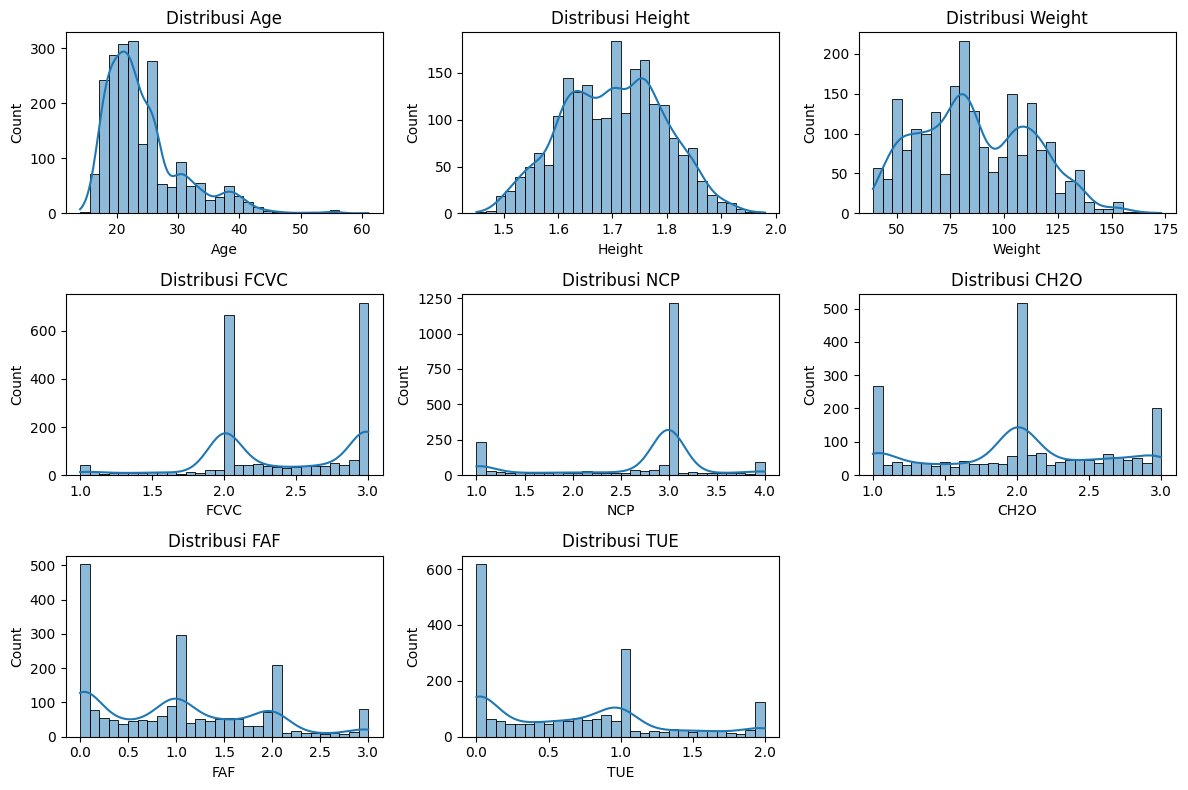

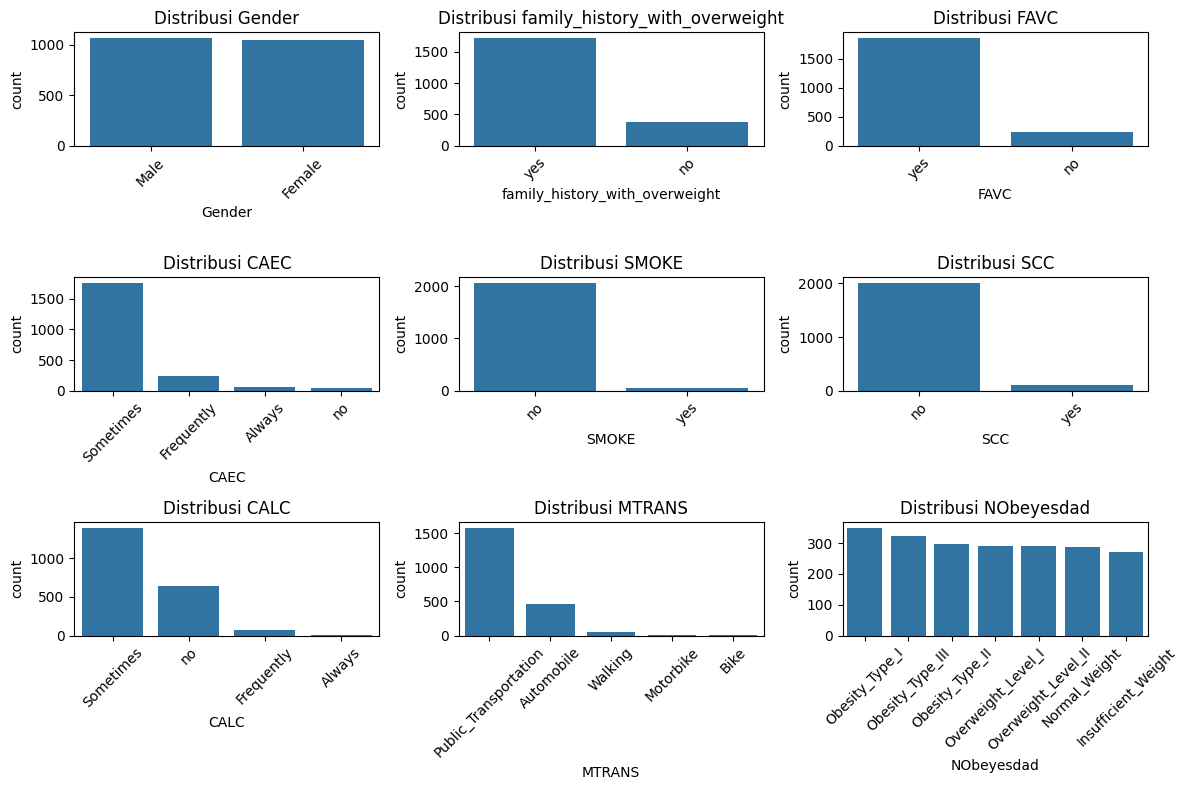

In [21]:
# Pisahkan kolom numerik dan kategorikal
numerical_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Visualisasi distribusi numerik
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

# Visualisasi distribusi kategorikal
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

In [22]:
# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Pisahkan fitur dan target
X = df_encoded.drop(columns=["NObeyesdad"])
y = df_encoded["NObeyesdad"]

# Normalisasi data numerik
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cek hasil setelah preprocessing
X_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
162,0,-0.522124,-0.768388,-1.015318,1,1,1.088342,0.404153,0,1,-0.013073,0,1.163820,-1.080625,2,3
2001,0,-0.533953,0.545156,1.796170,1,1,1.088342,0.404153,2,0,1.435437,0,0.553418,0.200030,2,3
1435,0,-0.222692,-0.428400,-0.152388,1,1,-2.276674,-1.710184,2,0,1.236246,0,-1.037118,1.645266,2,3
649,0,-0.390041,-1.218139,-1.617340,0,0,1.088342,-1.272151,1,0,0.884935,0,0.104145,-1.080625,3,3
1280,1,0.265136,1.178403,0.743025,1,1,1.088342,0.404153,2,0,1.387317,0,0.944295,0.036711,2,3


In [23]:
# Pilih fitur yang akan digunakan
selected_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender']
target = 'NObeyesdad'

# Encode gender (Female -> 0, Male -> 1)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# Encode target label
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

# Pisahkan fitur dan target
X = df[selected_features]
y = df[target]

# Split data menjadi train dan test set (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisasi fitur numerik
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cek ukuran dataset setelah split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1688, 9), (423, 9), (1688,), (423,))

In [24]:
# Inisialisasi model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Melatih dan mengevaluasi model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("="*60)

# Menampilkan hasil akurasi model
best_model = max(results, key=results.get)
best_model, results[best_model]


Random Forest Accuracy: 0.9598

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.91      0.95        54
      Normal_Weight       0.85      0.97      0.90        58
     Obesity_Type_I       0.96      0.97      0.96        70
    Obesity_Type_II       1.00      0.98      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.91      0.94        58
Overweight_Level_II       0.97      0.98      0.97        58

           accuracy                           0.96       423
          macro avg       0.96      0.96      0.96       423
       weighted avg       0.96      0.96      0.96       423

Support Vector Machine Accuracy: 0.9078

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.89      0.93        54
      Normal_Weight       0.81      0.86      0.83        58
     Obesity_Type_I       0.93      0.96      0.94        70
    Obes

('Random Forest', 0.9598108747044918)

# Simpan model dan scaler

"""
    Melakukan prediksi tingkat obesitas berdasarkan fitur input.
    
    Parameters:
    features (list): List berisi nilai fitur dalam urutan berikut:
        [Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE, Gender]
    
    Returns:
    str: Kategori obesitas yang diprediksi
    """

In [25]:
with open("trained_model.pkl", "wb") as model_file:
    pickle.dump((scaler, models["Random Forest"]), model_file)

# Fungsi untuk memuat model dan melakukan prediksi
def predict_obesity(features):
    # Muat model
    with open("trained_model.pkl", "rb") as model_file:
        scaler, model = pickle.load(model_file)
    
    # Normalisasi input
    features = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    # Prediksi
    prediction = model.predict(features_scaled)
    
    # Konversi hasil prediksi ke label asli
    return label_encoder.inverse_transform(prediction)[0]

# Contoh penggunaan
sample_data = [25, 1.75, 70, 2.0, 3.0, 2.0, 1.0, 0.5, 1]
result = predict_obesity(sample_data)
print(f"Prediksi Kategori Obesitas: {result}")

Prediksi Kategori Obesitas: Normal_Weight


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [27]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9479905437352246


In [28]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
selected_features.append('BMI')


In [29]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


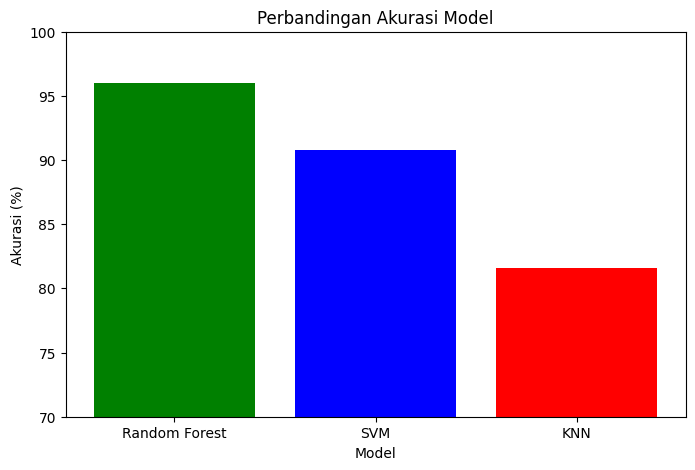

In [30]:
models = ["Random Forest", "SVM", "KNN"]
accuracy = [95.98, 90.78, 81.56]

plt.figure(figsize=(8,5))
plt.bar(models, accuracy, color=['green', 'blue', 'red'])
plt.xlabel("Model")
plt.ylabel("Akurasi (%)")
plt.title("Perbandingan Akurasi Model")
plt.ylim(70, 100)
plt.show()

In [31]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Latih model
for name, model in models.items():
    model.fit(X_train, y_train)


In [32]:
print("Random Forest Classification Report:")
print(classification_report(y_test, models["Random Forest"].predict(X_test), target_names=label_encoder.classes_))


Random Forest Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.91      0.95        54
      Normal_Weight       0.85      0.97      0.90        58
     Obesity_Type_I       0.96      0.97      0.96        70
    Obesity_Type_II       1.00      0.98      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.91      0.94        58
Overweight_Level_II       0.97      0.98      0.97        58

           accuracy                           0.96       423
          macro avg       0.96      0.96      0.96       423
       weighted avg       0.96      0.96      0.96       423



In [33]:
print("Random Forest Classification Report:")
print(classification_report(y_test, models["SVM"].predict(X_test), target_names=label_encoder.classes_))

Random Forest Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.89      0.93        54
      Normal_Weight       0.81      0.86      0.83        58
     Obesity_Type_I       0.93      0.96      0.94        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.79      0.83      0.81        58
Overweight_Level_II       0.87      0.83      0.85        58

           accuracy                           0.91       423
          macro avg       0.91      0.90      0.91       423
       weighted avg       0.91      0.91      0.91       423



In [34]:
print("Random Forest Classification Report:")
print(classification_report(y_test, models["KNN"].predict(X_test), target_names=label_encoder.classes_))

Random Forest Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.71      0.94      0.81        54
      Normal_Weight       0.75      0.52      0.61        58
     Obesity_Type_I       0.79      0.90      0.84        70
    Obesity_Type_II       0.91      0.98      0.94        60
   Obesity_Type_III       0.98      1.00      0.99        65
 Overweight_Level_I       0.79      0.59      0.67        58
Overweight_Level_II       0.75      0.74      0.75        58

           accuracy                           0.82       423
          macro avg       0.81      0.81      0.80       423
       weighted avg       0.82      0.82      0.81       423



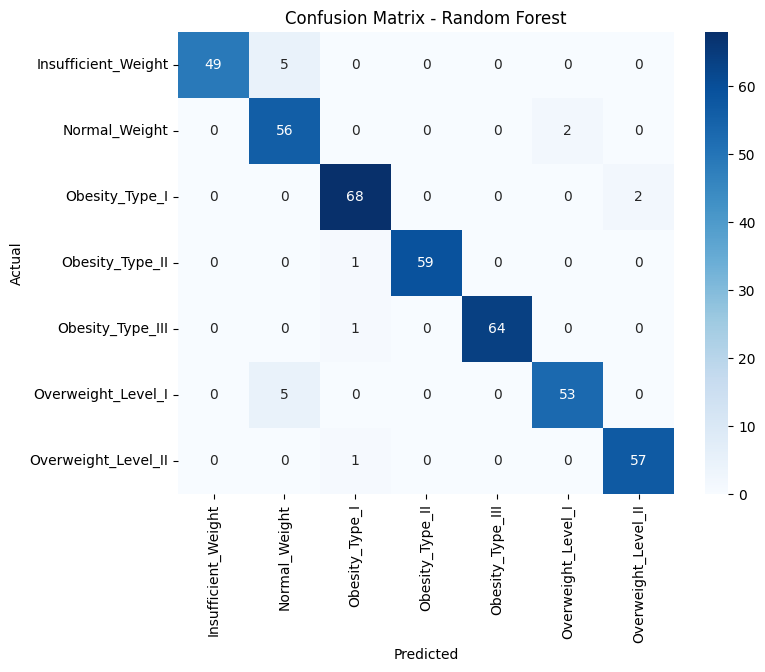

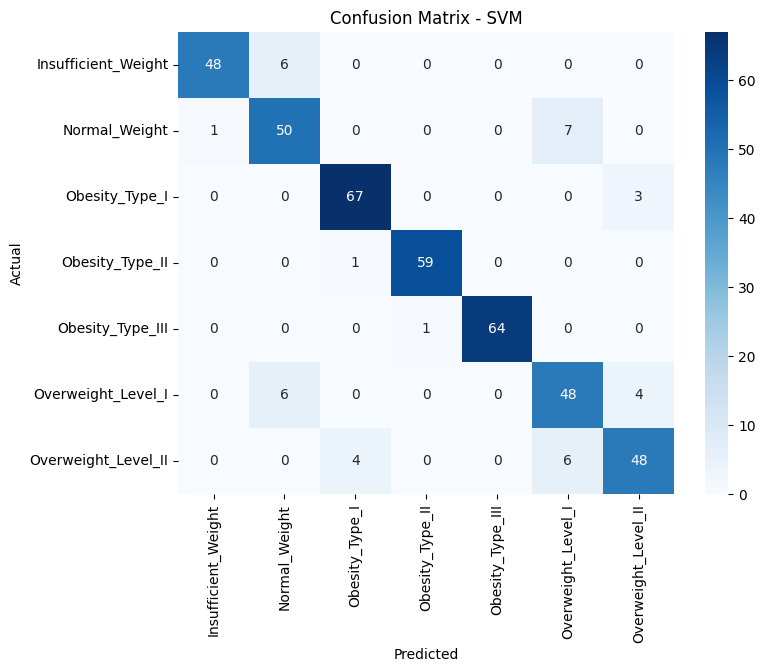

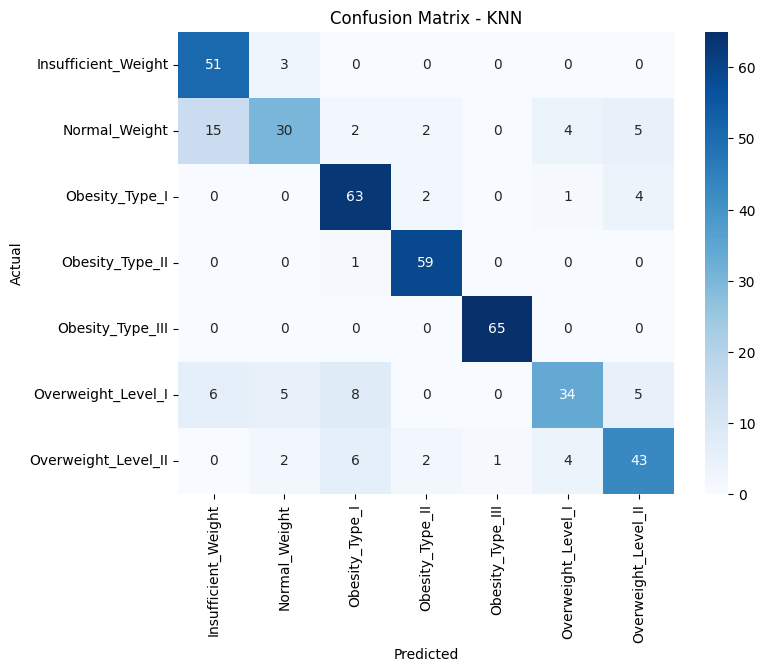

In [35]:
# Membuat confusion matrix untuk setiap model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


In [38]:
import pickle

# Path ke file yang diunggah
file_path = "../notebook/trained_model.pkl"

# Load isi file pickle
with open(file_path, "rb") as file:
    loaded_object = pickle.load(file)

# Periksa tipe data objek yang dimuat
type(loaded_object)

tuple

In [41]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Pisahkan data menjadi training dan testing set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inisialisasi dan latih model DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Periksa apakah model dapat melakukan prediksi
y_pred = model.predict(X_test_scaled)

# Simpan model dan scaler dengan joblib
joblib.dump(scaler, "../model/scaler.pkl")
joblib.dump(model, "../model/model.pkl")
joblib.dump(label_encoder, "../model/label_encoder.pkl")

# Tampilkan beberapa prediksi pertama
y_pred[:100]

array([0, 4, 0, 0, 1, 0, 3, 5, 2, 0, 2, 4, 2, 3, 4, 6, 4, 3, 2, 6, 2, 5,
       4, 2, 1, 6, 6, 4, 4, 0, 4, 5, 6, 1, 0, 4, 2, 1, 1, 1, 1, 3, 1, 1,
       5, 0, 3, 1, 2, 3, 1, 1, 1, 5, 0, 6, 3, 3, 1, 3, 1, 4, 6, 0, 2, 2,
       1, 4, 0, 0, 6, 6, 0, 0, 5, 3, 3, 5, 4, 3, 1, 2, 3, 3, 2, 2, 1, 6,
       1, 6, 5, 3, 0, 5, 2, 0, 5, 2, 1, 3])

In [49]:
# Path ke file yang diunggah
test_data_path = "../data/processed_train_data.csv"

# Baca file data uji
df_test = pd.read_csv(test_data_path)

# Tampilkan beberapa baris pertama untuk memeriksa strukturnya
df_test.head(100)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,NObeyesdad
0,-0.830923,0.620541,-0.289869,-0.809585,0.402353,1.601927,-0.024257,2.242022,0.987051,5
1,-0.361495,0.513995,-0.635417,-0.809585,0.402353,1.601927,-0.024257,0.576454,0.987051,1
2,-0.987399,-0.018735,-1.199811,1.080202,0.402353,-0.029305,2.336114,-1.089115,0.987051,1
3,-0.751685,1.307219,0.042472,0.690076,1.419764,0.670590,1.267506,-0.433950,0.987051,5
4,-1.130536,-1.770158,-1.124592,-0.861469,-0.449641,-0.500610,-1.091715,0.894666,-1.013119,5
...,...,...,...,...,...,...,...,...,...,...
95,-0.205018,-2.362746,-1.019359,-0.809585,-2.177938,-1.660537,-1.204443,-1.089115,-1.013119,6
96,0.225076,-0.351478,0.699709,1.080202,0.402353,-0.801830,-0.991823,0.156579,-1.013119,4
97,2.188638,0.930686,0.518954,-0.782762,-0.823129,0.271995,1.156591,0.333099,0.987051,2
98,-0.645585,-0.005054,0.692188,0.425808,-1.835452,-1.059498,-0.946743,0.190160,0.987051,3


In [50]:
# Load model, scaler, dan label encoder
model = joblib.load("../model/model.pkl")
scaler = joblib.load("../model/scaler.pkl")
label_encoder = joblib.load("../model/label_encoder.pkl")

# Pisahkan fitur dan target
X_test_new = df_test[selected_features]
y_test_new = df_test[target]

# Pastikan dataset sudah dalam skala yang benar
X_test_new = scaler.transform(X_test_new)  # Normalisasi

# Konversi ke array numpy jika perlu
X_test_new = X_test_new.to_numpy()

# Prediksi
y_pred_new = model.predict(X_test_new)

# Konversi hasil prediksi ke label kategori
y_pred_labels = label_encoder.inverse_transform(y_pred_new)

# Tampilkan hasil pertama
list(zip(y_test_new[:5], y_pred_labels[:5]))

KeyError: "['BMI'] not in index"